In [2]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as skpp
# XGBoost
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
import xgboost as xgb # must be in AMN_windows env
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List


# PATH = "biolog_data.txt"
# all_data = pd.read_csv(PATH, comment="<", encoding='cp1252', delimiter="\t")
PATH = "biolog_data_metabolic_genes.csv"
all_data = pd.read_csv(PATH, index_col=0)
# all_data_norm = (all_data - all_data.mean()) - all_data.std()
all_data

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
194,b4100 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.19,Blattner Laboratory
406,b4100 mutant Biolog assay,OD600 growth,(5) 4-Amino-Imidazole-4(5)-Carboxamide,2.07,Blattner Laboratory
618,b4100 mutant Biolog assay,OD600 growth,"1,2-Propanediol",0.20,Blattner Laboratory
724,b4100 mutant Biolog assay,OD600 growth,1-Thio-b-D-Glucose,0.61,Blattner Laboratory
1042,b4100 mutant Biolog assay,OD600 growth,"2,3-Butanediol",0.15,Blattner Laboratory
...,...,...,...,...,...
100040,b3567 mutant Biolog assay,OD600 growth,Uridine-3’-monophosphate,0.46,Blattner Laboratory
100252,b3567 mutant Biolog assay,OD600 growth,Uridine-5’-monophosphate,0.91,Blattner Laboratory
100358,b3567 mutant Biolog assay,OD600 growth,Xanthine,0.80,Blattner Laboratory
100570,b3567 mutant Biolog assay,OD600 growth,Xanthosine,0.22,Blattner Laboratory


<AxesSubplot:xlabel='Data Value', ylabel='Count'>

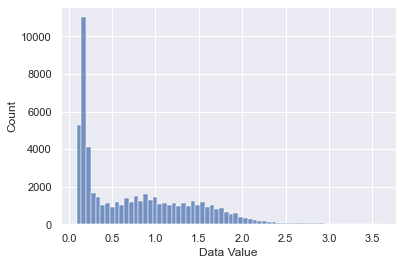

In [7]:
plt.close('all')
sns.set_theme()
sns.histplot(all_data["Data Value"])

In [3]:
print("Unique mutants number: ", len(set(all_data['Experiment Description'])))
print("Unique substrates number: ", len(set(all_data['Well Substrate'])))

Unique mutants number:  120
Unique substrates number:  390


In [4]:
target_gene_encoder = skpp.OneHotEncoder()
which_CS_encoder = skpp.OneHotEncoder()

raw_target_gene = all_data["Experiment Description"].values.reshape(-1, 1)
raw_which_medium = all_data["Well Substrate"].values.reshape(-1, 1)

target_gene_encoder.fit(raw_target_gene)
which_CS_encoder.fit(raw_which_medium)

X_left = target_gene_encoder.transform(raw_target_gene).toarray()
X_right = which_CS_encoder.transform(raw_which_medium).toarray()

X = np.hstack((X_left, X_right))

# raw_X = all_data.iloc[:,:3].values
# enc.fit(raw_X)
# X = enc.transform(raw_X).toarray()

Y = all_data["Data Value"].values.reshape(-1, 1)
print(X.shape, Y.shape)

(57500, 510) (57500, 1)


In [5]:
LOO_split = int(Y.shape[0])

xgb_preds = []

for i in range(5):

    # XGBoost = xgb.XGBRegressor(n_estimators=600, max_depth=2, learning_rate=0.01, objective='reg:squarederror', random_state=i)
    multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))

    xgb_pred = cvp(multioutputregressor, X, Y, cv=KFold(n_splits=10, shuffle=True, random_state=i), n_jobs = 5)
    
    xgb_preds.append(xgb_pred)

In [6]:
mean_xgb_pred = np.array(xgb_preds).mean(axis=0)
std_xgb = np.array(xgb_preds).std(axis=0)

print("Mean squared error between mean prediction and true fluxes", np.mean((mean_xgb_pred - Y)**2, axis=0))
# MSE between mean prediction (over 5 times 10-fold test sets) and true

print("Q²: ", r2_score(Y, mean_xgb_pred))

Mean squared error between mean prediction and true fluxes [0.19152584]
Q²:  0.5257438275118369
